In [3]:
!pip install gensim scikit-learn xgboost catboost
!pip install --upgrade --force-reinstall numpy pandas scikit-learn xgboost catboost gensim --quiet

  Using cached pandas-2.3.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
Using cached pandas-2.3.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2,

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
from collections import defaultdict
from gensim.models import Word2Vec
from google.colab import drive

# 📂 드라이브 마운트
drive.mount('/content/drive')

# 경로 설정
file_path = '/content/drive/MyDrive/movie/filtered_over_100k_utf8sig.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# 1. 데이터 로딩 및 배우 리스트 전처리
df = pd.read_csv("/content/drive/MyDrive/movie/filtered_over_100k_utf8sig.csv")
df['actor_list'] = df['actors'].fillna('').apply(lambda x: [a.strip() for a in x.split('|') if a.strip()])

# 2. Word2Vec 학습
actor_sentences = df['actor_list'].tolist()
model = Word2Vec(sentences=actor_sentences, vector_size=64, window=3, min_count=2, sg=1, negative=10, epochs=50, seed=42)

# 3. 타겟 인코딩
actor_target = [(a, t) for actors, t in zip(df['actor_list'], df['audiCnt']) for a in actors]
actor_df = pd.DataFrame(actor_target, columns=['actor', 'target'])
actor_avg_target = actor_df.groupby('actor')['target'].mean().to_dict()

def get_target_encoded_feature(actor_list):
    values = [actor_avg_target.get(a, 0) for a in actor_list]
    return np.mean(values) if values else 0

df['actor_target_enc'] = df['actor_list'].apply(get_target_encoded_feature)

# 4. 장르 원핫 인코딩
df['genre_list'] = df['genres'].fillna('').apply(lambda x: x.split('|'))
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df['genre_list'])

# 5. 국가 가중치 인코딩
nation_avg = df.groupby('nations')['audiCnt'].mean()
nation_weights = (nation_avg / nation_avg.max()).to_dict()
df['nation_weight_encoded'] = df['nations'].apply(lambda x: nation_weights.get(x, 0.0))

# 6. X, y 구성
X = np.hstack([
    df[['actor_target_enc']].values,
    genre_encoded,
    df[['nation_weight_encoded']].values
])
y = np.log1p(df['audiCnt'].values)

# 7. 피처 이름 정의
feature_names = ['actor_target_enc'] + list(mlb.classes_) + ['nation_weight_encoded']

# 8. 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 9. 모델 정의
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42),
    "CatBoost": CatBoostRegressor(n_estimators=100, verbose=0, random_state=42)
}

# 10. 성능 평가 및 학습
trained_models = {}

def eval_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
    r2 = r2_score(np.expm1(y_test), np.expm1(y_pred))
    print(f"{name:<15} RMSE: {rmse:,.2f} | R²: {r2:.4f}")
    trained_models[name] = model

for name, model in models.items():
    eval_model(name, model)


Random Forest   RMSE: 1,391,951.20 | R²: 0.5722
XGBoost         RMSE: 1,542,502.93 | R²: 0.4747


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 293
[LightGBM] [Info] Number of data points in the train set: 772, number of used features: 16
[LightGBM] [Info] Start training from score 13.381135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [5]:
# 📌 나눔고딕 설치
!apt-get update -qq
!apt-get install -y fonts-nanum

# 📌 matplotlib 캐시 삭제
import matplotlib as mpl
import shutil
import os

mpl_cache = os.path.join(os.path.expanduser("~"), ".cache", "matplotlib")
if os.path.exists(mpl_cache):
    shutil.rmtree(mpl_cache)


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [1]:
# ✅ matplotlib에 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지


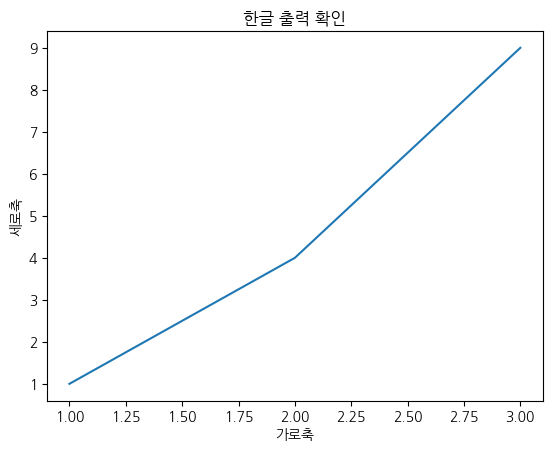

In [2]:
plt.title("한글 출력 확인")
plt.plot([1, 2, 3], [1, 4, 9])
plt.xlabel("가로축")
plt.ylabel("세로축")
plt.show()


In [14]:
import matplotlib.font_manager as fm

# 윈도우 시스템 폰트 목록 확인
for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    if 'malgun' in font.lower():
        print(font)

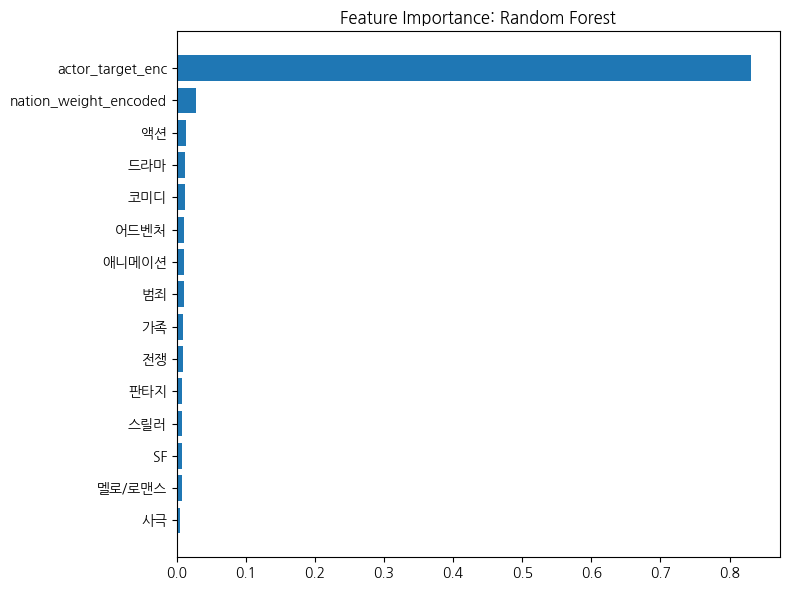

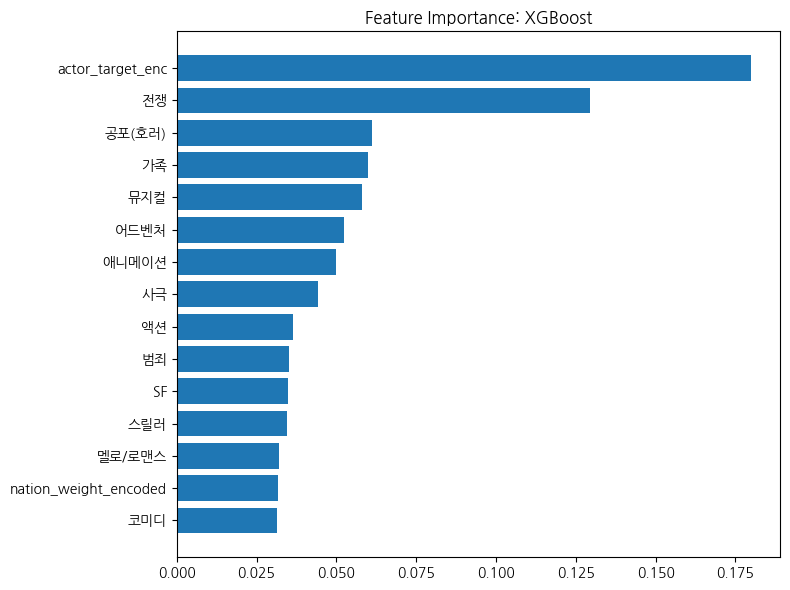

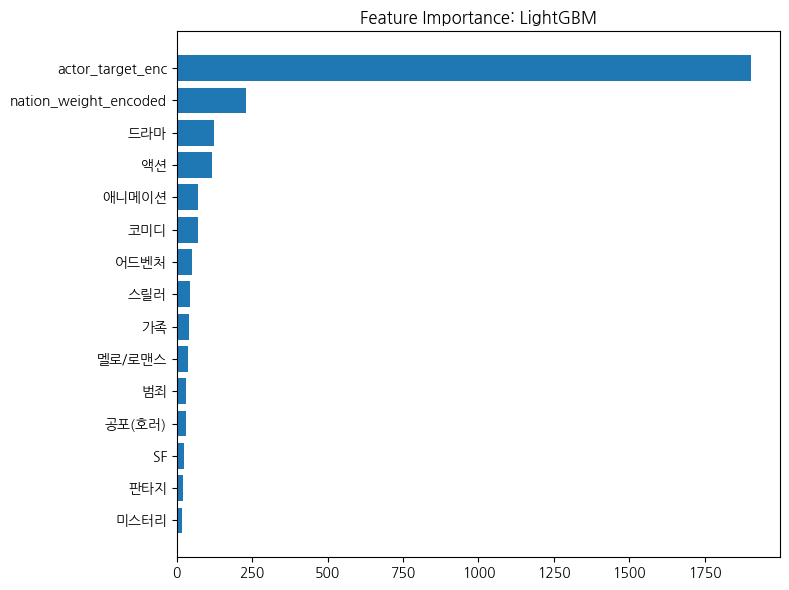

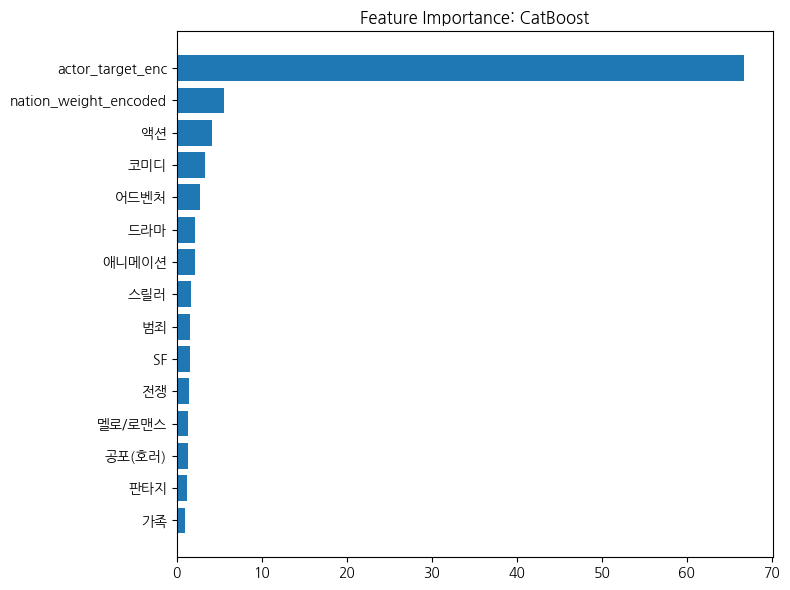

In [8]:
# 11. 중요도 시각화 함수
def plot_feature_importance(model, name, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:15]
    plt.figure(figsize=(8, 6))
    plt.title(f"Feature Importance: {name}")
    plt.barh(range(len(indices)), importances[indices], align="center")
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# 12. 모델별 중요도 시각화
for name, model in trained_models.items():
    plot_feature_importance(model, name, feature_names)


🔍 SHAP Summary for: XGBoost


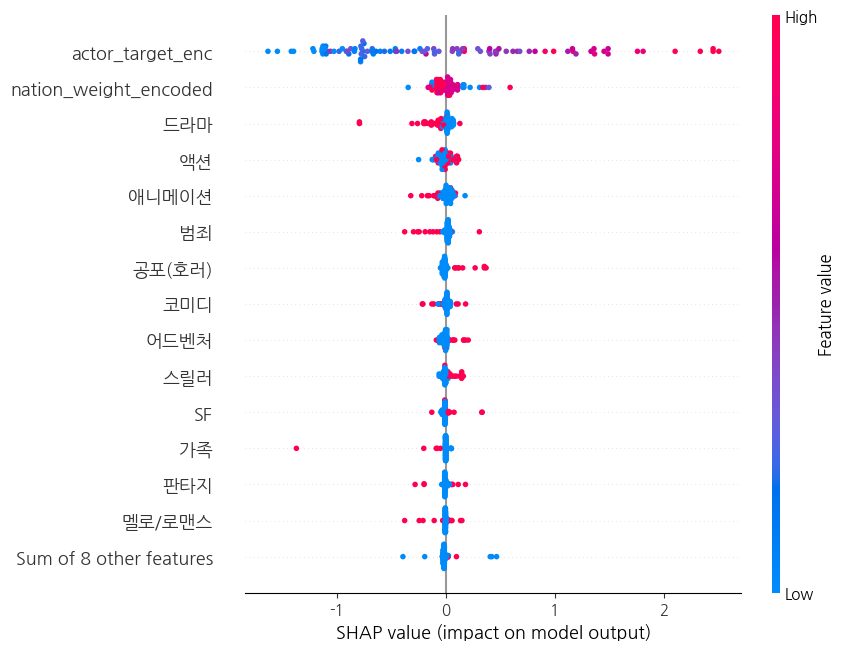

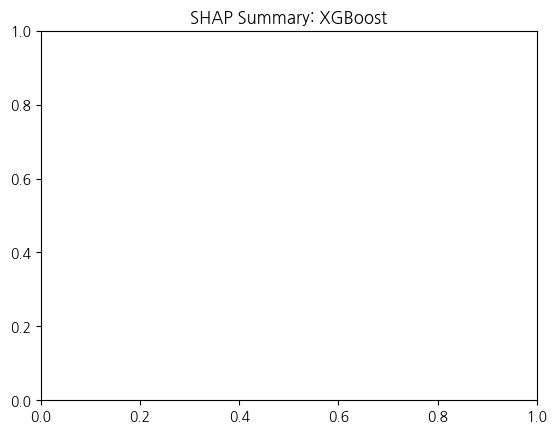


🔍 SHAP Summary for: LightGBM


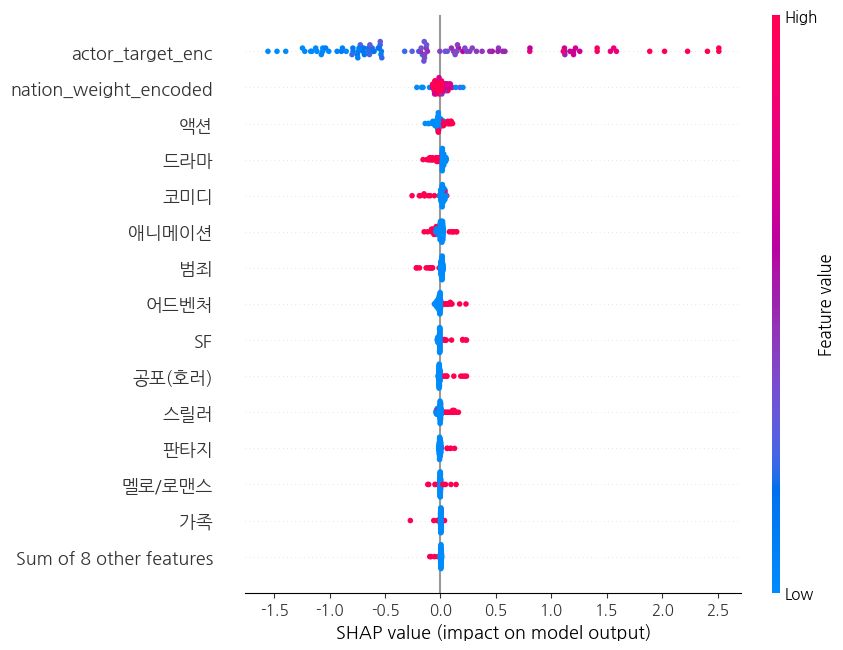

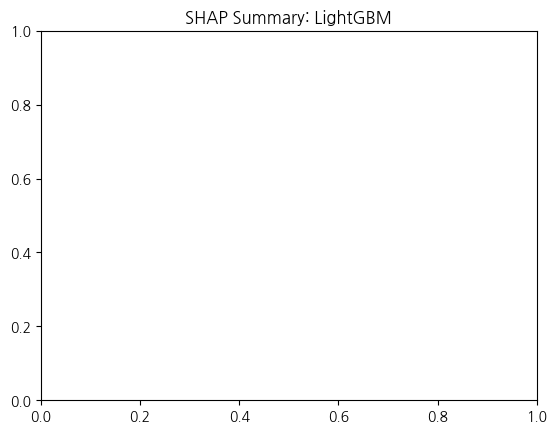


🔍 SHAP Summary for: CatBoost


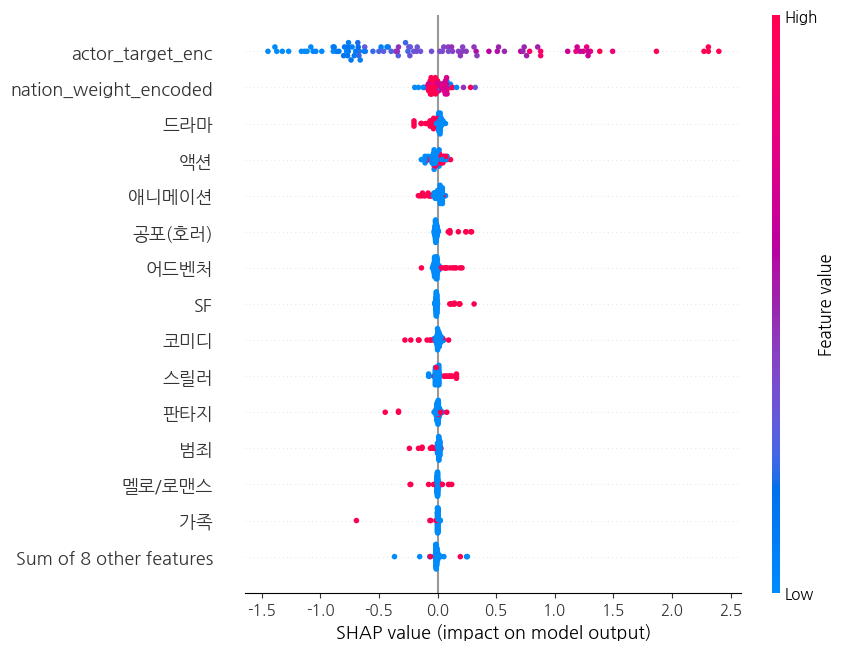

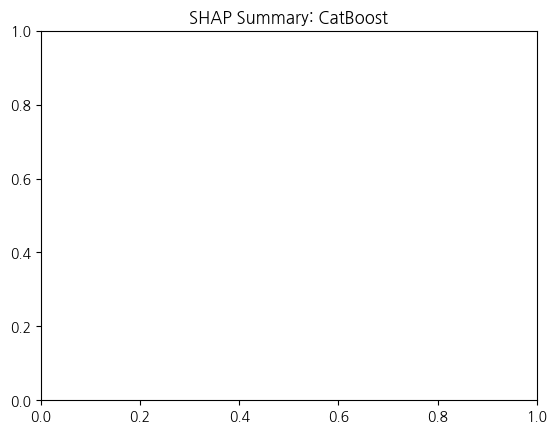


🔍 SHAP Summary for: Random Forest


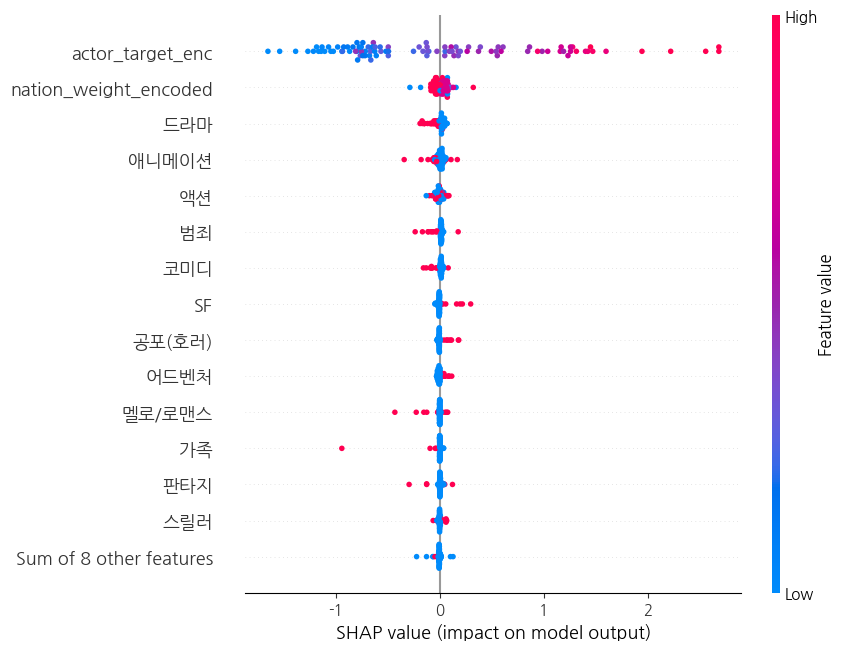

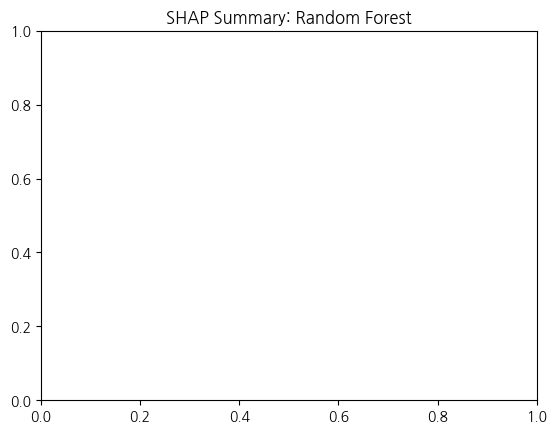

In [9]:
import shap
import matplotlib.pyplot as plt

# ✅ SHAP 시각화 함수 정의
def run_shap(model, model_name, X_train, X_test, feature_names):
    print(f"\n🔍 SHAP Summary for: {model_name}")
    explainer = shap.Explainer(model, X_train, feature_names=feature_names)
    shap_values = explainer(X_test[:100])  # 100개 샘플만 계산

    # Summary Plot (beeswarm 형태)
    shap.plots.beeswarm(shap_values, max_display=15)
    plt.title(f"SHAP Summary: {model_name}")
    plt.show()

# ✅ SHAP 실행 (모델 이름과 일치하는 key를 사용해야 함)
run_shap(trained_models["XGBoost"], "XGBoost", X_train, X_test, feature_names)
run_shap(trained_models["LightGBM"], "LightGBM", X_train, X_test, feature_names)
run_shap(trained_models["CatBoost"], "CatBoost", X_train, X_test, feature_names)
run_shap(trained_models["Random Forest"], "Random Forest", X_train, X_test, feature_names)



🔍 SHAP Summary for: XGBoost (전체 샘플)


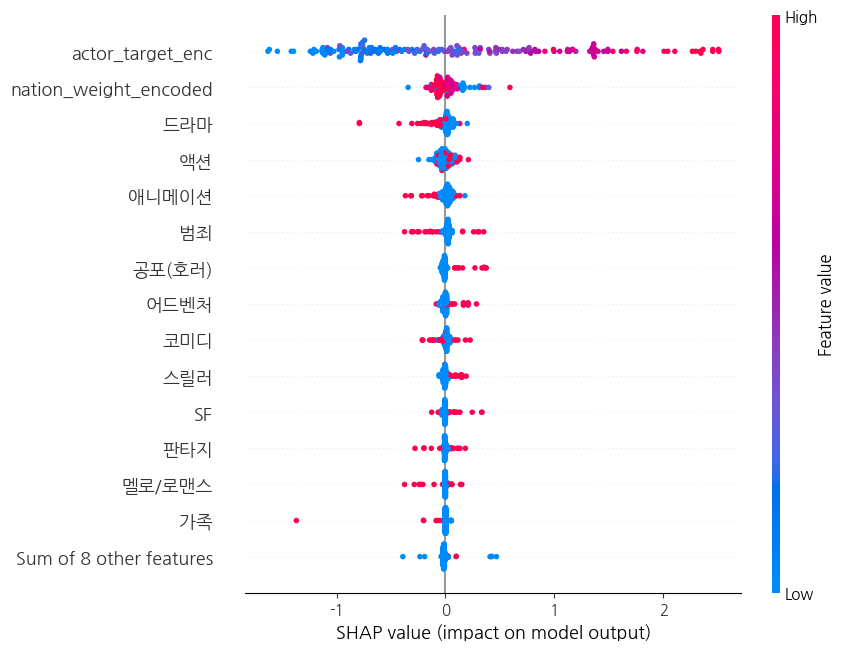

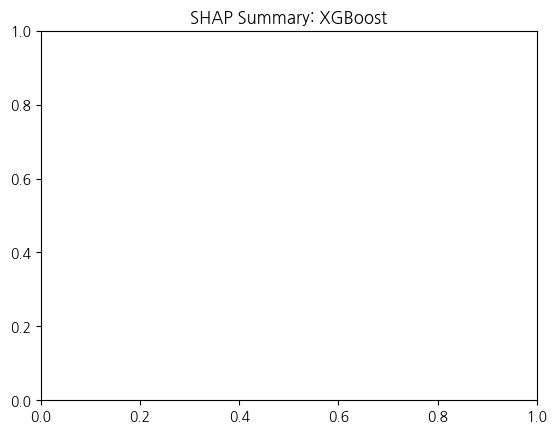


🔍 SHAP Summary for: LightGBM (전체 샘플)


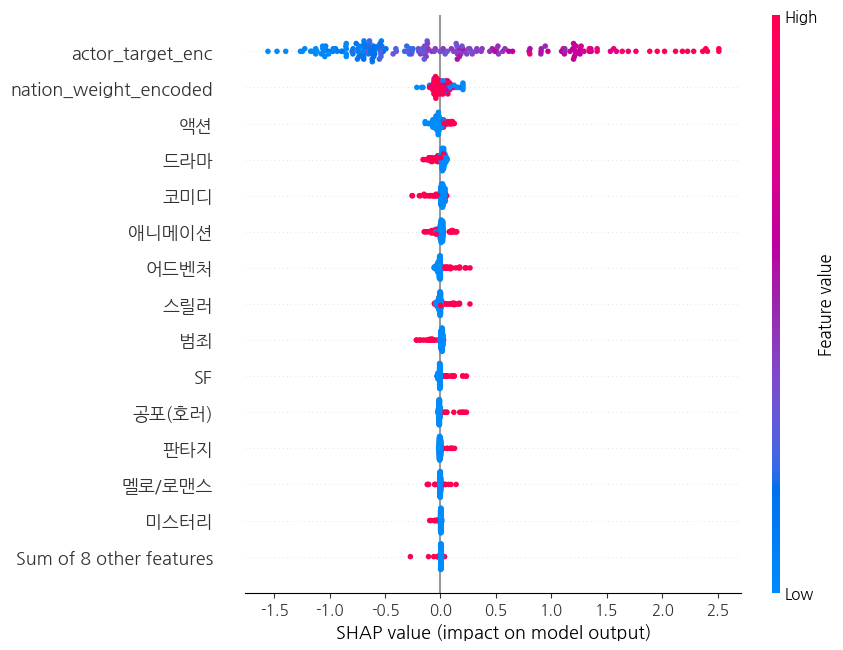

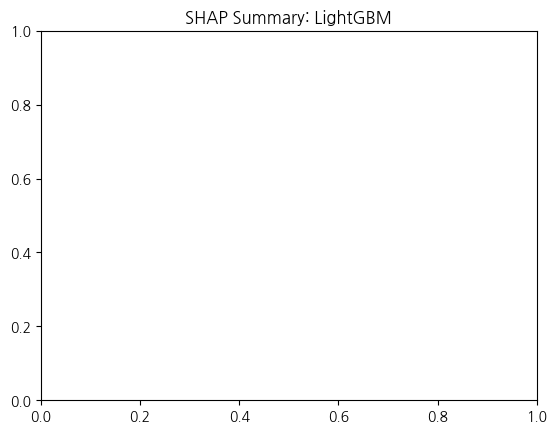


🔍 SHAP Summary for: CatBoost (전체 샘플)


PermutationExplainer explainer: 194it [00:38,  4.26it/s]


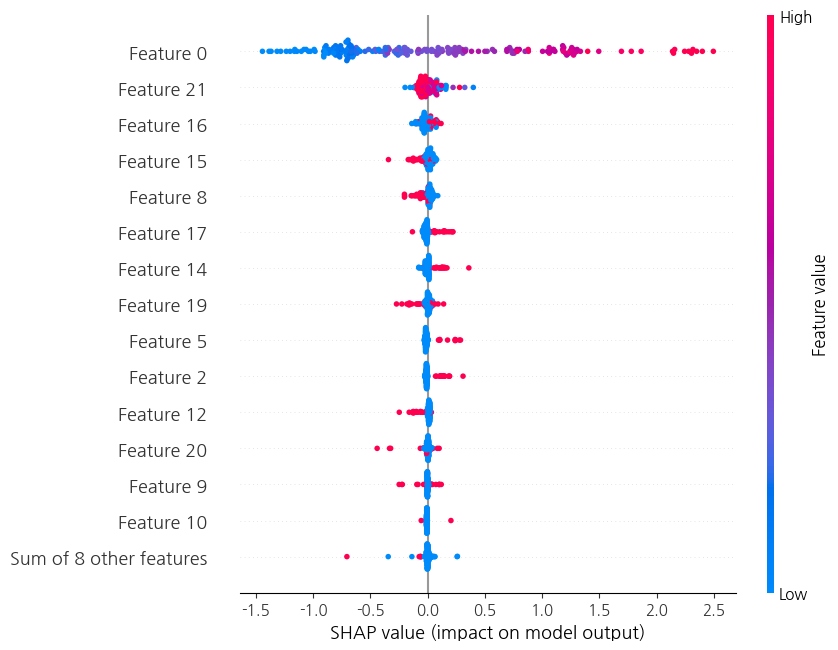

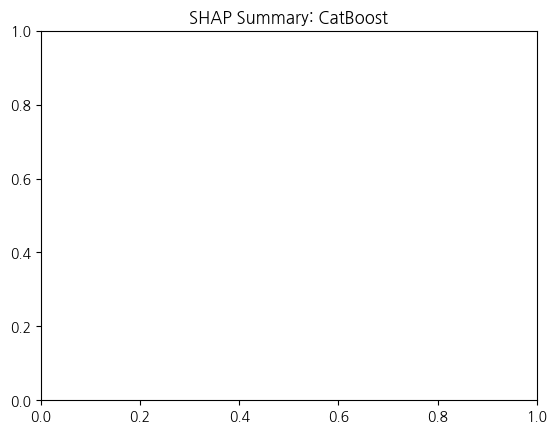


🔍 SHAP Summary for: Random Forest (전체 샘플)


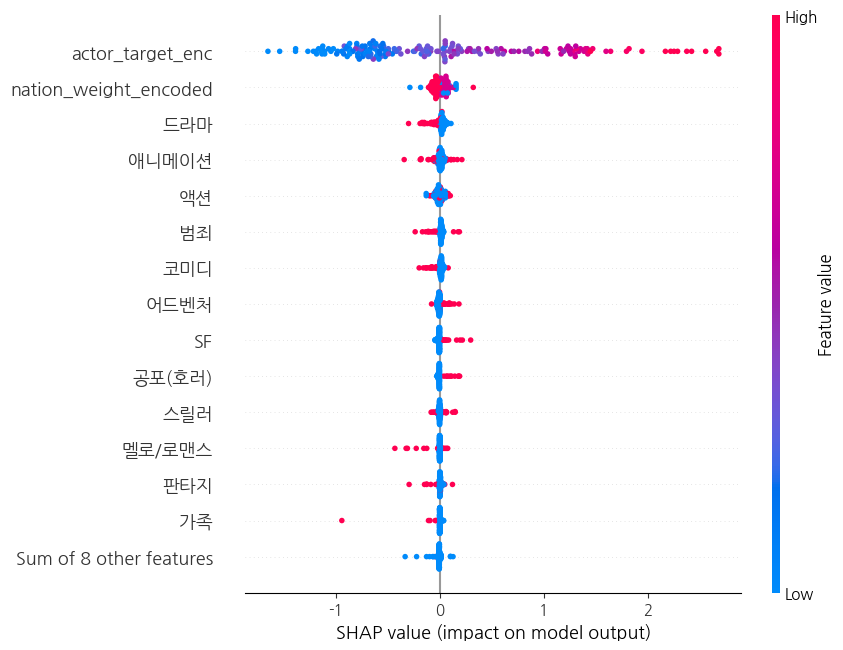

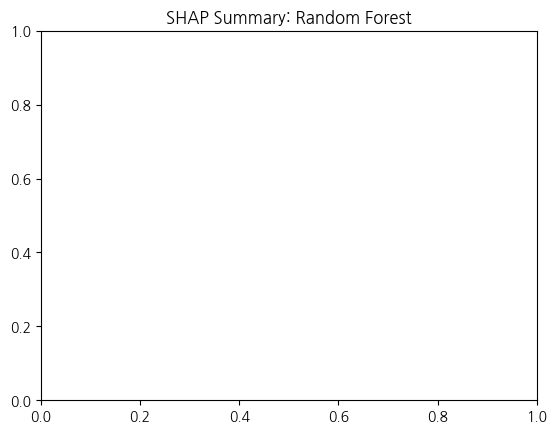

In [10]:
import shap
import matplotlib.pyplot as plt

# ✅ SHAP 전체 데이터 시각화 함수
def run_shap_full(model, model_name, X_train, X_test, feature_names):
    print(f"\n🔍 SHAP Summary for: {model_name} (전체 샘플)")

    # 모델 종류별 explainer 설정
    if model_name == "CatBoost":
        explainer = shap.Explainer(model.predict, X_train)
    else:
        explainer = shap.Explainer(model, X_train, feature_names=feature_names)

    shap_values = explainer(X_test)  # 전체 테스트셋에 대해 SHAP 계산

    shap.plots.beeswarm(shap_values, max_display=15)
    plt.title(f"SHAP Summary: {model_name}")
    plt.show()

# ✅ 4개 모델에 대해 전체 SHAP 계산
run_shap_full(trained_models["XGBoost"], "XGBoost", X_train, X_test, feature_names)
run_shap_full(trained_models["LightGBM"], "LightGBM", X_train, X_test, feature_names)
run_shap_full(trained_models["CatBoost"], "CatBoost", X_train, X_test, feature_names)
run_shap_full(trained_models["Random Forest"], "Random Forest", X_train, X_test, feature_names)
